In [175]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import tqdm.auto as tqdm

In [164]:
class FaceDataset(data.Dataset):
    def __init__(self, path, over_sample=False):
        y, X = np.split(np.genfromtxt(path, delimiter=','), [1], axis=-1)
        y = y.squeeze()
        if over_sample:
            X, y = RandomOverSampler().fit_resample(X, y)
        X = X.reshape(-1, 1, 48, 48)
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)
        return self
    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [251]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, 5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Flatten(),

            nn.Linear(24*24*256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 7)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, X):
        return self.model(X)

    def predict(self, X):
        return torch.argmax(self.forward(X), dim=-1)
    
    def evaluate(self, X, y):
        model.eval()
        yhat = self.predict(X)
        yhat = yhat.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        print(f'acc: {accuracy_score(y, yhat):.5f}', end=' | ')
        print(f'p: {precision_score(y, yhat, average="micro"):.5f}', end=' | ')
        print(f'r: {recall_score(y, yhat, average="micro"):.5f}', end=' | ')
        print(f'f1: {f1_score(y, yhat, average="micro"):.5f}', end=' | ')
        print(f'P: {precision_score(y, yhat, average="macro"):.5f}', end=' | ')
        print(f'R: {recall_score(y, yhat, average="macro"):.5f}', end=' | ')
        print(f'F1: {f1_score(y, yhat, average="macro"):.5f}')
#         print(f'accuracy: {accuracy_score(y, yhat):.5f}')
#         print(f'precision (micro): {precision_score(y, yhat, average="micro"):.5f}')
#         print(f'recall (micro): {recall_score(y, yhat, average="micro"):.5f}')
#         print(f'f1 (micro): {f1_score(y, yhat, average="micro"):.5f}')
#         print(f'precision (macro): {precision_score(y, yhat, average="macro"):.5f}')
#         print(f'recall (macro): {recall_score(y, yhat, average="macro"):.5f}')
#         print(f'f1 (macro): {f1_score(y, yhat, average="macro"):.5f}')

In [267]:
def train(model, opt, data_loader, n_epochs, test_set=None):
    losses = []
    for epoch in tqdm.tqdm(range(n_epochs)):
        if test_set:
            print(f'Epoch {epoch}:-')
            model.evaluate(test_set.X, test_set.y)
            print()
        model.train()
        for X, y in data_loader:
            yhat = model(X)
            loss = model.criterion(yhat, y)
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            losses.append(loss.item())
    if test_set:
        print(f'Epoch {epoch+1}:-')
        model.evaluate(test_set.X, test_set.y)
    return losses

In [268]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device:', device)

device: cuda


In [269]:
#train_set = FaceDataset('train.csv', over_sample=True).to(device)

In [270]:
#test_set = FaceDataset('public_test.csv').to(device)

In [275]:
model = Model().to(device)

In [281]:
opt = optim.Adam(model.parameters(), lr=1e-3)
data_loader = data.DataLoader(train_set, batch_size=128, shuffle=True)

In [282]:
train_losses = train(model, opt, data_loader, 4, test_set)

Epoch 0:-
acc: 0.53000 | p: 0.53000 | r: 0.53000 | f1: 0.53000 | P: 0.45196 | R: 0.41667 | F1: 0.42021

Epoch 1:-
acc: 0.56000 | p: 0.56000 | r: 0.56000 | f1: 0.56000 | P: 0.45693 | R: 0.44910 | F1: 0.44734

Epoch 2:-
acc: 0.56000 | p: 0.56000 | r: 0.56000 | f1: 0.56000 | P: 0.48331 | R: 0.44600 | F1: 0.44658

Epoch 3:-
acc: 0.58000 | p: 0.58000 | r: 0.58000 | f1: 0.58000 | P: 0.49030 | R: 0.46099 | F1: 0.45742


Epoch 4:-
acc: 0.57000 | p: 0.57000 | r: 0.57000 | f1: 0.57000 | P: 0.47245 | R: 0.45617 | F1: 0.44701


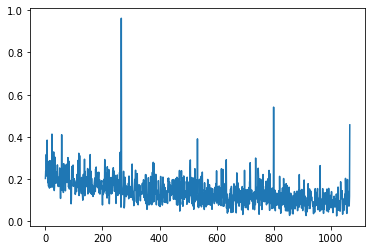

In [283]:
plt.plot(train_losses)
plt.show()

In [284]:
model.evaluate(test_set.X, test_set.y)

acc: 0.57000 | p: 0.57000 | r: 0.57000 | f1: 0.57000 | P: 0.47245 | R: 0.45617 | F1: 0.44701
